In [1]:
import os
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as pth
from PIL.Image import *
from matplotlib import cm
from PIL import Image
import cv2
from PIL import Image
import scipy
from scipy import signal as sg
from scipy import ndimage

In [2]:
import sys
import os
print(os.path.dirname(sys.executable))

C:\Anaconda


# Image

In [3]:
def multiple_imshow(rows,cols,images ,titles):

    plt.figure(len(images), figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(rows,cols,i+1)
        plt.imshow(images[i],'gray')
        plt.title(titles[i])
        #plt.xticks([]),plt.yticks([]) 
    plt.show()

def defect_detection(path,lower_bound,upper_bound,lower_bound_1 = [0,0,0],upper_bound_1 =[0,0,0]):
    
    img = cv2.imread(path,1)  # BGR color image reading and 0 flag for gray
    
    #blur = cv2.GaussianBlur(img,(5,5),0) #not good results
    #kernel = np.ones((5,5),np.float32)/25 #averaging is not satisfying as well
    #dst = cv2.filter2D(img,-1,kernel)
    #median = cv2.medianBlur(img,5)#median as well
    
    # converting it into Hue, saturation, value (HSV)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
   
    '''Threshold'''
    
    # define range of red color in HSV
    lower = np.array(lower_bound)
    upper = np.array(upper_bound)
    
    # Threshold the HSV image to get only red colors
    mask_0 = cv2.inRange(hsv, lower, upper)
    mask_1 = cv2.inRange(hsv,np.array(lower_bound_1),np.array(upper_bound_1))
    mask =mask_0 + mask_1
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask = mask)
    
    return res


def pre_shaping(image,resol = [284,348]):
    
    #width = resol[1]
    #height = resol[0]
    #dim = (width, height) 
    
    # resize image
    #resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)#INTER_LINEAR_EXACT) 
    
    img = image
    rows,cols = img.shape
    
    frame = [[0,0],[cols,0],[0,rows],[cols,rows]]
    dimension = [[0,0],[resol[1],0],[0,resol[0]],[resol[1],resol[0]]]

    pts1 = np.float32(frame)
    pts2 = np.float32(dimension)

    M = cv2.getPerspectiveTransform(pts1,pts2)
    resized = cv2.warpPerspective(img,M,(resol[1],resol[0]))
    
    return resized

def real_shaping(normalized_image,rows_dim,cols_dim,i = 8,j = 17):
    
    img = normalized_image
    rows,cols = img.shape
    
    frame = [[i,j],[rows,j],[i,cols],[rows,cols]]
    dimension = [[0,0],[cols_dim,0],[0,rows_dim],[cols_dim,rows_dim]]

    pts1 = np.float32(frame)
    pts2 = np.float32(dimension)

    M = cv2.getPerspectiveTransform(pts1,pts2)

    real_shape = cv2.warpPerspective(img,M,(cols_dim,rows_dim))
    
    return real_shape

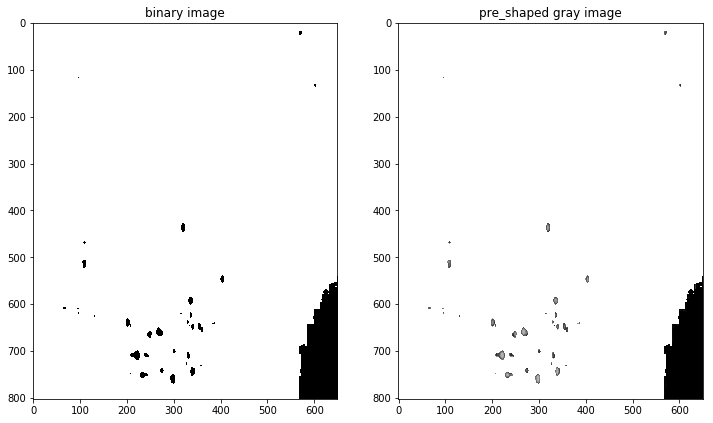

In [4]:
'''Functions call'''

path = "C:/Users/elh/Desktop/xy.png"

''' Big defects : red_yellow'''

lower_bound = [0,0,0]
upper_bound = [55,255,255] # for more defects the upper bound can go till ~105

res = defect_detection(path,lower_bound,upper_bound,[155,0,0],[179,255,255])

"""Binary image to detect the center"""
imgray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY) #convert to gray

#binary thresholding 
ret,thresh = cv2.threshold(imgray,0,1,cv2.THRESH_BINARY)
#th2 = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            #cv2.THRESH_BINARY,11,2) #consider some defects as noise


title = 'Global Thresholding (big defects)'

'''shaping'''
#gray image

#img = pre_shaping(img,resol = [350,285])
images = [255-thresh,255-imgray]#255-img]#i,j --> y,x
titles = ['binary image','pre_shaped gray image']

multiple_imshow(1,2,images ,titles)


In [5]:
pre_processed_img = imgray # pre_shaped gray image

# Gradient(1,0) and (0,1)

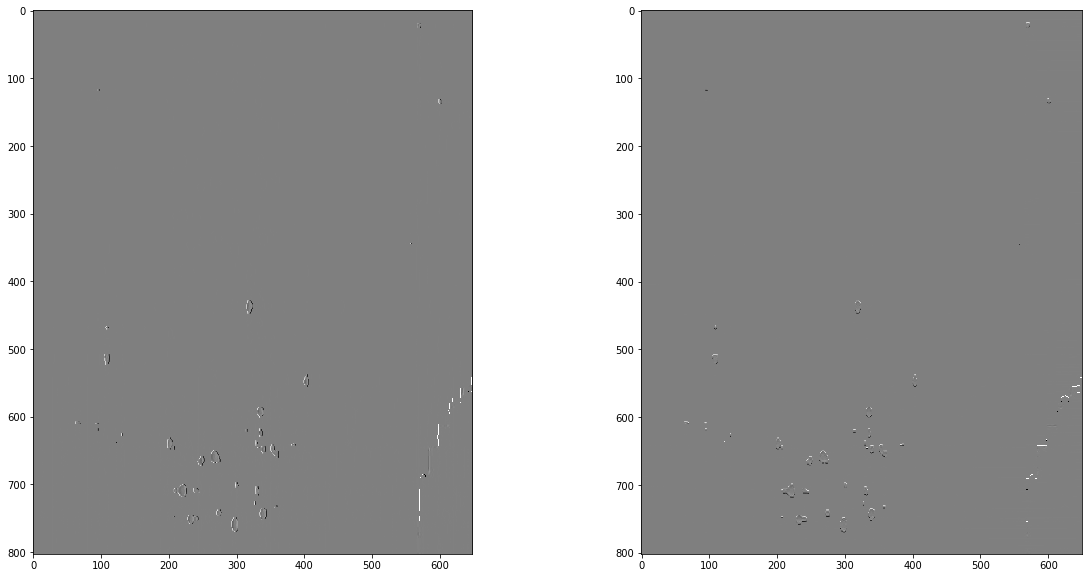

In [6]:
Gx = sg.convolve(imgray, [[1., -1]], "valid")
Gy = sg.convolve(imgray, [[1.], [-1]], "valid")

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(Gx, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(Gy, cmap='gray');

In [7]:
Gx.shape

(803L, 649L)

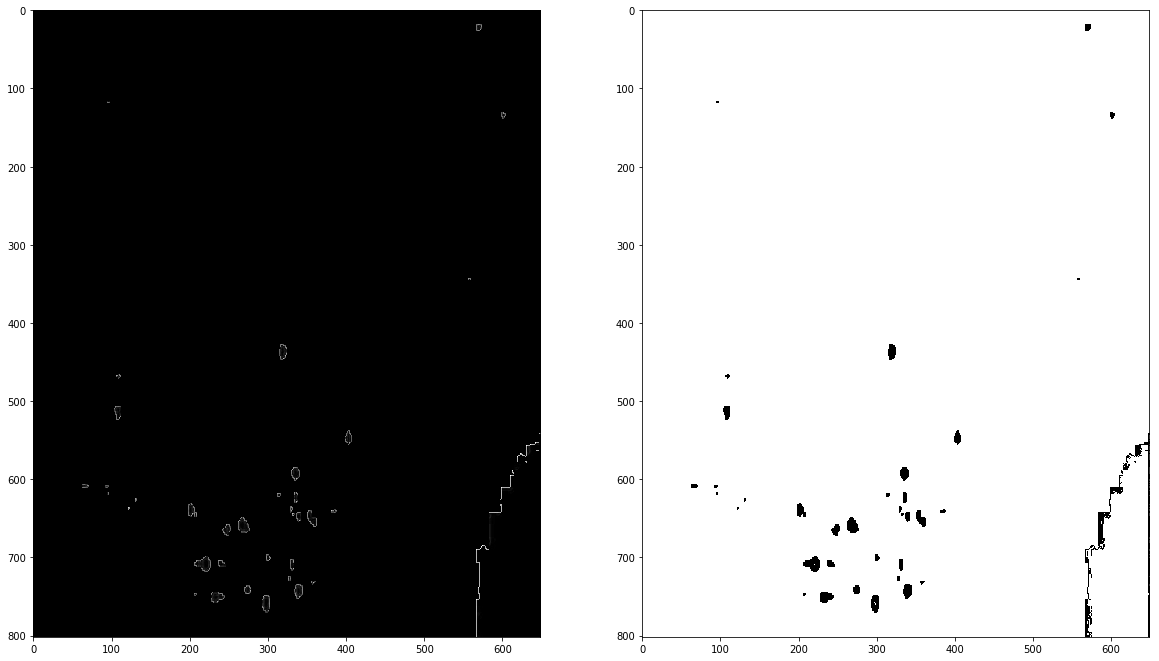

In [8]:
N = np.sqrt(Gx[1:,:]**2 + Gy[:,1:]**2)
S = 1

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(20,12))
ax0.imshow(N,cmap="gray")
ax1.imshow(N<S, cmap="gray");

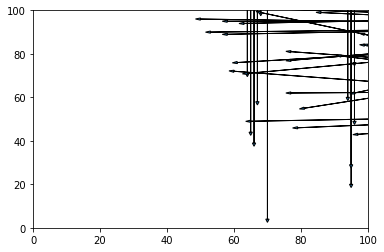

In [9]:
plt.xlim(0,100)
plt.ylim(0,100)

for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        if N[i,j] > S:
            plt.arrow(j,N.shape[0]-i, 1*Gx[i,j], -1*Gy[i,j],head_width=1)

In [10]:
plt.style.use("default")
import IPython

np.set_printoptions(linewidth=500,suppress=True,precision=5)

## One defect

In [11]:
def add_neighbours_in_stack(image, a, b, stack, i, j, inComponent):

    inComponent[i, j] = True
    neighbours = [(i+1,j),(i-1,j),(i,j-1),(i,j+1)]
    #neighbours = [(i-1,j-1),(i+1,j-1),(i+1,j),(i-1,j),(i,j-1),(i,j+1),(i-1,j+1),(i+1,j+1)]
    for (k,l) in neighbours:
        if 0<=k<image.shape[0] and 0<=l<image.shape[1]:
            if (image[k,l]>a and image[k,l]<b) and not inComponent[k, l]:
                inComponent[k, l] = True
                stack.append((k,l))
    return 

def connected_component_nb(image, seuil, i0,j0, inComponent):
    stack = [(i0,j0)]
    defect = []
    nb=1
    barycentre = [i0,j0]
    while len(stack)>0:
        (i,j) = stack.pop()
        nb+=1  
        add_neighbours_in_stack(image, seuil, 260, stack, i, j, inComponent)
        
        defect.append((i,j))
        barycentre[0] += i
        barycentre[1] += j
            
    barycentre[0] /= nb
    barycentre[1] /= nb
    
    return nb, barycentre,defect


def all_connected_components(image, seuil):

    inComponent = np.empty(image.shape, dtype=np.bool)
    inComponent[:, :] = False # stoping test

    baryAndSizes = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j]>seuil and not inComponent[i,j]:
                baryAndSizes.append(connected_component_nb(image,seuil,i,j,inComponent))
                
    return baryAndSizes


def step2(image,defect_nb,thresh):
    
    imageR = image
    imageB = image

    baryAndSizesR = all_connected_components(imageR, thresh)
    baryAndSizesB = all_connected_components(imageB, thresh)
    
    xR, xB = np.array([],dtype=int), np.array([],dtype=int)
    yR, yB = np.array([],dtype=int), np.array([],dtype=int)
    sizeR, sizeB = np.array([]), np.array([]) 
    
    for i in range(len(baryAndSizesR)):
        xR = np.append(xR, baryAndSizesR[i][1][0])
        yR = np.append(yR, baryAndSizesR[i][1][1])
        sizeR = np.append(sizeR, baryAndSizesR[i][0])
    
    for i in range(len(baryAndSizesB)):
        xB = np.append(xB, baryAndSizesB[i][1][0])
        yB = np.append(yB, baryAndSizesB[i][1][1])
        sizeB = np.append(sizeB, baryAndSizesB[i][0])
    
    '''plot'''
    fig, ax = plt.subplots(1,3, figsize = (22,12))
    fig.suptitle('Results', fontsize=16)
    ax[0].set_xlim(0,imageR.shape[1])
    ax[1].set_xlim(0,imageB.shape[1])
    ax[2].set_xlim(0,imageB.shape[1])
    
    title = ['Detected defects centers','Detected defects as discs']
    ax[0].imshow(255-imageR, cmap='gray', vmin = 0, vmax = 255,)
    ax[0].scatter(yR, xR, marker='+', s=sizeR, c = 'r', alpha = 0.5)
    ax[0].set_title(title[0])
    
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    ax[1].imshow(255-imageB, cmap='gray', vmin = 0, vmax = 255,)
    ax[1].scatter(yB, xB, marker='o', s=sizeB, c = 'b', alpha = 0.5)
    ax[1].set_title(title[1])
    
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    
    '''defects list''' 
    #print(baryAndSizesB[0][2])#exemple of defect 0
    test = np.array([],dtype=int)
    test = baryAndSizesB[defect_nb][2] #i.e defect number 10
    test_x = np.ndarray(len(test))
    test_y = np.ndarray(len(test))
    for i in range(len(test)):
        test_x[i] = test[i][1] #x axis
        test_y[i] = test[i][0] #y axis
    
    ax[2].imshow((255-imageR), cmap='gray', vmin = 0, vmax = 255,)
    ax[2].scatter(test_x, test_y, marker='o', s=1, c = 'b', alpha = 0.5)

    test = np.stack((test_x, image.shape[0]-test_y), axis=1)
    
    plt.show()
    
    return yR, image.shape[0]-xR, sizeR,test

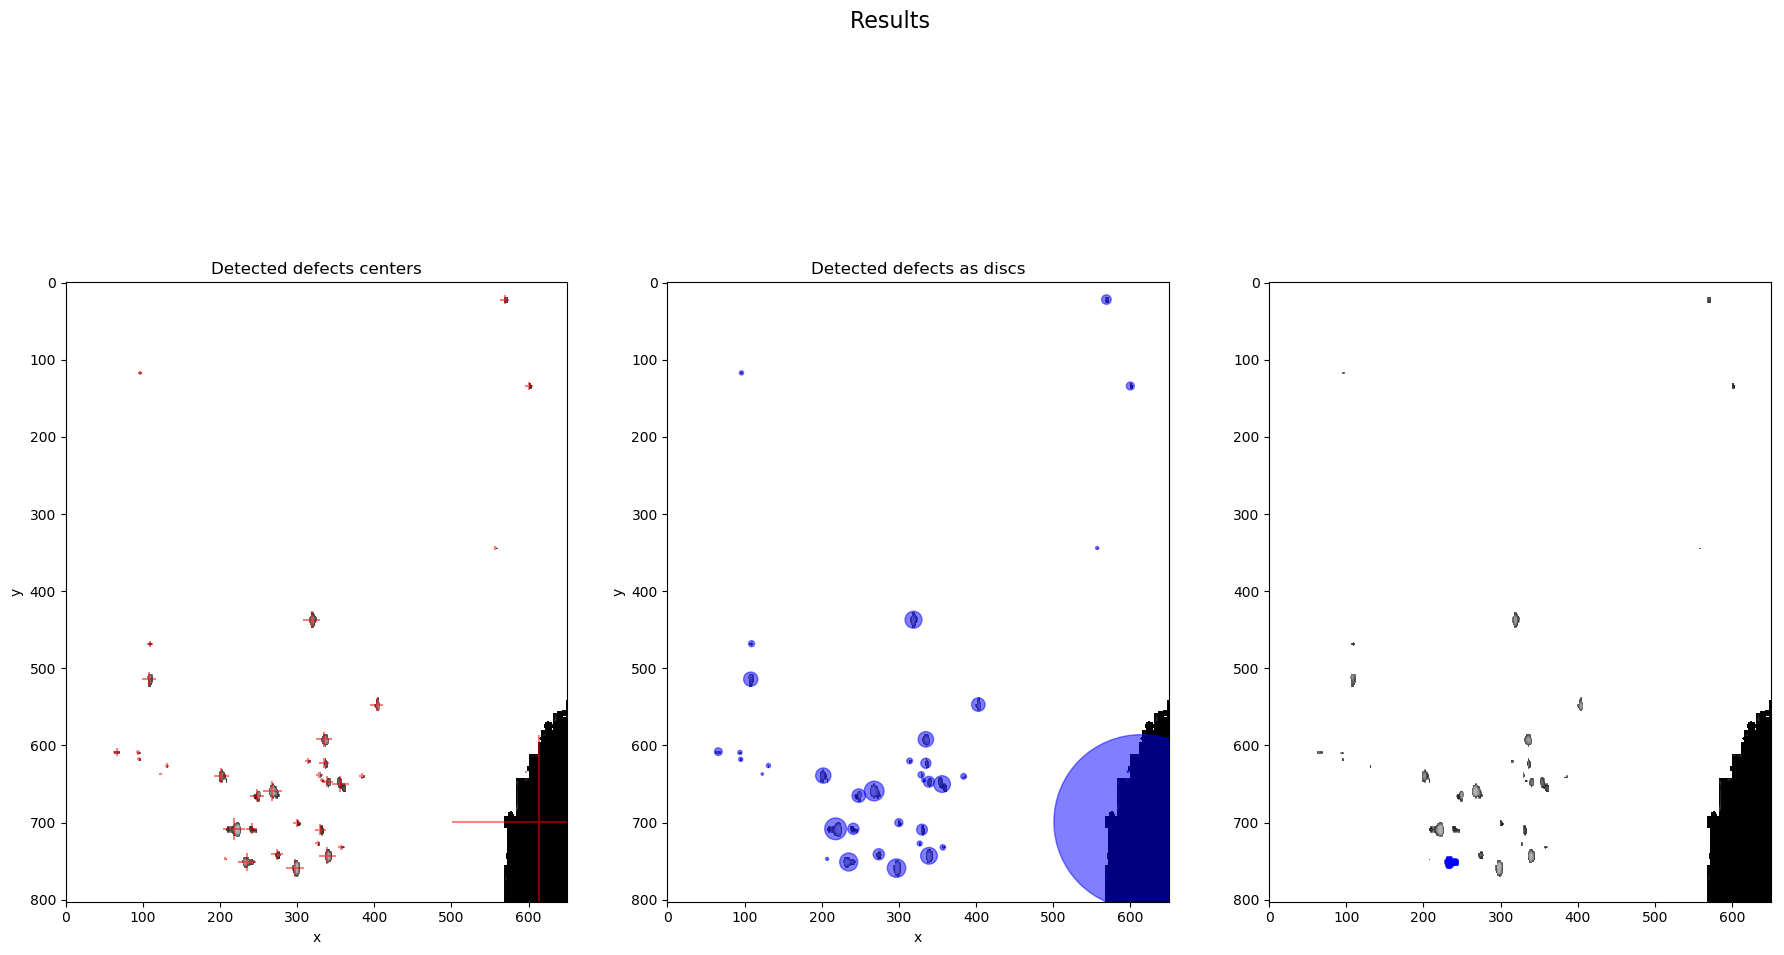

37


In [12]:
'''Call function'''
image = pre_processed_img
#image = cv2.GaussianBlur(imgray,(3,3),0)

x, y,area ,test= step2(image,34,0)#34 no bluring #27 for 50 thresh
xy = np.stack((x, y), axis=1)
print len(x)

In [13]:
def get_defect_intensity(img,defect): #pixel should np.array (x,y)
    
    defect = np.array(defect,dtype=np.uint64)
    intensity = img[img.shape[0]-defect[:,1],defect[:,0]]
    
    return intensity

In [14]:
defect = np.array(test,dtype=np.uint64)

In [15]:
get_defect_intensity(imgray,defect).size

168

In [16]:
img = image
#img = cv2.GaussianBlur(imgray,(3,3),0)
test.shape,img.shape

((168L, 2L), (803L, 650L))

In [17]:
get_defect_intensity(img,defect).shape

(168L,)

In [18]:
def defect_matrix(img,defect,(a,b)):
    
    i_min = np.min(img.shape[0]- defect[:,1])#starting line index
    i_max = np.max(img.shape[0]- defect[:,1]+1)#last line index (+1 for python)
    j_min = np.min(defect[:,0])#starting column index
    j_max = np.max(defect[:,0]+1)#last column index (+1 for python)
    
    defect_shape = img[i_min:i_max,j_min:j_max].shape
    dim = np.max(defect_shape)
    case = np.zeros((dim,dim))

    assert (img[i_min:i_max,j_min:j_max][img[i_min:i_max,j_min:j_max]!= 0.].size == get_defect_intensity(img,defect).size)

    case[0:defect_shape[0],0:defect_shape[1]] = img[i_min:i_max,j_min:j_max].copy()
    case = cv2.GaussianBlur(case,(a,b),0) #smoothing
    
    return case

## Gaussian filter

In [19]:
case = defect_matrix(img,defect,(7,7)) # gaussian

In [20]:
df = pd.DataFrame(case)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,59.893555,74.399902,106.264648,133.926270,148.730957,154.416504,153.193359,141.474121,115.171387,81.770508,57.219727,47.316406,45.194336,41.114746,30.266602,17.737793,12.336914
1,68.857422,81.889160,109.555908,132.316406,143.543213,147.734375,147.718262,139.933105,119.826660,93.002441,73.128662,65.598389,63.876465,58.314209,44.168945,27.829102,20.740723
2,90.403320,99.484619,116.549805,127.655518,130.807129,131.643066,134.041504,134.894531,129.218506,118.272705,109.712402,107.508545,106.467529,98.036621,77.950684,54.699707,44.492188
3,113.561523,117.437744,121.935791,120.538330,115.794189,113.481934,117.575195,125.905518,133.948730,138.869141,141.432129,143.440186,142.585938,133.633545,113.578857,90.099854,79.549316
4,130.900879,129.747314,123.439453,112.585205,102.679932,98.541992,102.983887,114.716309,130.295166,144.705566,153.764160,157.291748,156.531982,150.804443,138.855469,124.193359,117.170898
5,138.892090,134.517578,121.845459,106.135254,94.145996,89.521973,93.711914,105.856445,123.516113,141.175293,152.376465,155.777588,155.245605,153.580566,150.870117,146.298584,143.411133
6,138.490723,133.550537,119.771973,103.435791,91.439209,86.979980,91.147217,103.162354,120.973389,139.060059,150.402344,153.264404,152.619141,152.484131,153.322998,152.508057,151.047363
7,132.020020,129.189209,119.274414,105.877930,95.223389,91.042725,95.476074,107.656494,125.128906,142.083984,151.912598,153.483887,151.705811,149.603516,147.004883,142.273193,138.949707
8,121.786621,122.901855,120.532715,112.885498,104.790283,101.211670,105.970459,117.578125,132.257324,143.996826,148.239014,146.129395,141.953369,136.346680,127.795410,116.660889,110.558105
9,109.788086,114.980469,121.376709,121.554688,117.935791,115.985840,120.225830,127.958008,134.158447,134.101074,127.392822,118.859375,111.912598,104.524658,93.689453,80.555420,73.867676


## Plot

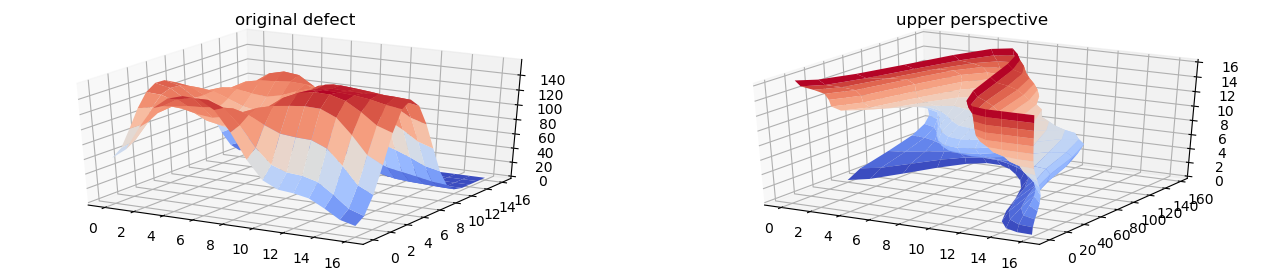

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=plt.figaspect(0.2))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')


# Make data.
X = np.arange(0, case.shape[0], 1)
Y = np.arange(0, case.shape[0], 1)
X, Y = np.meshgrid(X, Y)
Z = (case,case)

# Plot the surface.
surf0 = ax0.plot_surface(X, Y, Z[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)


# Add a color bar which maps values to colors.

ax1 = fig.add_subplot(1, 2, 2, projection='3d')

surf1 = ax1.plot_surface( Y, Z[0],X, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

ax0.set_title('original defect')
ax1.set_title('upper perspective')
plt.savefig('fig')

plt.show()

In [22]:
case.shape

(17L, 17L)

# Gaussian mask

In [23]:
def gaussian_mask(shape=(3, 3), sigma=0.5):

    if len(shape)!=2: raise ValueError("len-2 shape required")
    if shape[0]%2!=1 or shape[1]%2!=1: raise ValueError("only odd sizes are OK")

    m,n = (shape[0]-1)/2,(shape[1]-1)/2
    y,x = np.ogrid[-m:m+1,-n:n+1]
    res = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )

    
    """normalization"""
    res/=res.sum()
    return res

# Sobel operator

In [24]:
def getCompassOperators(kind):
    res=np.empty([8,3,3])
    
    if kind=="kirsch":
        conv_mask = np.array([5,  5, 5,-3,-3,-3,-3,-3])
    elif kind=="robinson2":
        conv_mask = np.array([1,2,1,0,-1,-2,-1,0])
    elif kind=="robinson1":
        conv_mask = np.array([1,1,1,0,-1,-1,-1,0])
    
    
    for i in range(8):
        oneDir=np.zeros(9)
        oneDir[[0,1,2,5,8,7,6,3]]=conv_mask
        "to turn the coef"
        conv_mask=np.concatenate([conv_mask[1:],conv_mask[0:1]])
        res[i,:,:]=oneDir.reshape([3,3])
        
    return res

In [25]:
op = getCompassOperators("robinson2")
directions = ["N", "NW", "W", "SW", "S", "SE", "E", "NE"]
for i in range(8):
    print(directions[i])
    print(op[i])

N
[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]]
NW
[[ 2.  1.  0.]
 [ 1.  0. -1.]
 [ 0. -1. -2.]]
W
[[ 1.  0. -1.]
 [ 2.  0. -2.]
 [ 1.  0. -1.]]
SW
[[ 0. -1. -2.]
 [ 1.  0. -1.]
 [ 2.  1.  0.]]
S
[[-1. -2. -1.]
 [ 0.  0.  0.]
 [ 1.  2.  1.]]
SE
[[-2. -1.  0.]
 [-1.  0.  1.]
 [ 0.  1.  2.]]
E
[[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]
NE
[[ 0.  1.  2.]
 [-1.  0.  1.]
 [-2. -1.  0.]]


We compute the gradients accoring to the 4 possible directions:

In [26]:
operators=getCompassOperators("robinson2")
all_grad = np.abs(np.array([sg.convolve(case, operators[i,:,:], "valid") for i in range(4)]))
all_grad.shape

(4L, 15L, 15L)

### Grad_y

In [27]:
df_grad_y = pd.DataFrame(all_grad[0,:,:])
df_grad_y

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,90.964355,39.384277,20.180176,64.891846,82.622559,67.656738,18.263916,58.016846,139.544189,201.679688,234.150146,239.660400,222.801025,189.251953,153.763184
1,128.181152,48.530273,38.925293,101.528564,126.396973,108.566162,44.076172,60.083252,174.158936,260.315430,302.696533,310.580078,298.758057,276.409912,252.760010
2,107.912598,28.971680,51.378174,104.425781,125.386963,115.394531,70.337402,8.407959,97.994141,164.319580,193.682617,202.679932,216.504883,244.071045,272.570801
3,59.399902,2.496094,50.544678,81.659424,93.431396,91.735596,74.394043,38.608154,5.124023,36.532227,48.278809,57.603760,89.844971,150.728271,213.550537
4,11.528809,12.681152,33.207031,43.192871,46.201416,46.789307,44.266357,35.843018,23.974609,16.396484,15.329346,10.173340,13.914062,58.929443,104.973389
5,20.099854,10.727783,2.008301,3.418213,5.883057,6.849121,6.977051,5.934326,2.966309,2.312744,8.591064,13.350342,15.359131,15.732910,16.377441
6,37.240723,0.322510,33.011230,50.383545,56.637695,58.293945,54.938721,41.920410,18.994141,6.524902,27.099121,44.604004,68.468262,103.039795,137.711182
7,48.547119,5.672607,56.168213,86.044678,97.348389,94.744141,74.382324,30.377686,31.456055,91.646973,133.562012,159.289795,183.266357,213.427490,241.833008
8,74.127441,13.574463,52.060303,98.786621,117.167480,103.197754,52.088623,33.836914,135.559570,223.230957,276.998047,299.477783,304.673096,302.296631,296.552002
9,130.739258,72.741943,2.321533,64.192627,88.028076,61.297852,14.173096,118.833252,220.672119,292.726074,327.372314,332.962158,319.352051,292.491455,262.806396


### Grad_NW

In [28]:
df_grad_NW = pd.DataFrame(all_grad[1,:,:])
df_grad_NW

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,179.095703,167.223633,76.801514,7.072266,47.977295,65.997070,82.420898,79.286377,21.113770,76.564697,149.435547,155.429443,102.727051,44.368896,41.984863
1,167.851807,117.849121,14.955811,61.430420,82.954102,70.549316,46.389648,4.627686,69.571533,158.414795,213.511475,205.307861,146.207275,89.644287,99.572998
2,104.709229,36.191406,48.951660,93.410645,86.966553,52.487549,11.297363,33.662354,83.007568,126.660889,144.576172,126.849609,88.536621,69.684570,113.904541
3,26.186279,39.857422,90.742188,97.724121,67.820557,22.939941,19.144043,50.096191,62.630615,57.347412,42.732178,26.453125,18.838867,36.010254,94.178711
4,35.501221,84.672852,100.849365,79.064453,35.061523,13.738525,54.229248,74.684570,63.429199,28.358154,3.448242,15.725098,9.113770,10.592773,45.239502
5,63.282471,89.965088,81.834229,45.563477,3.888916,54.215576,94.460205,109.965576,87.130615,38.357666,1.418213,16.668213,19.754639,26.456055,30.141846
6,59.310303,63.880615,44.564697,5.932373,43.546875,92.633301,126.288818,127.380371,86.251709,23.375244,24.239746,48.381592,70.485840,104.504395,129.432129
7,36.749268,23.183105,2.742920,31.254395,76.128174,114.946777,123.953125,88.337402,12.526611,68.836426,120.910156,147.494385,175.269531,211.097412,225.229492
8,19.012695,12.072266,32.652344,60.030029,92.300781,104.020752,67.599609,18.106934,126.676758,212.161621,251.033936,262.703857,274.773193,287.335205,273.474121
9,27.465332,22.442871,46.231689,63.233643,70.169922,40.481201,42.725586,156.584473,257.918945,307.841064,306.805420,289.386719,278.517090,268.017822,238.164062


### Grad_x

In [29]:
df_grad_x = pd.DataFrame(all_grad[2,:,:])
df_grad_x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,153.914551,188.551758,124.698242,55.313721,16.046875,25.293457,98.628174,170.186768,170.853760,100.026367,33.774658,30.241943,82.859619,127.684082,98.244629
1,101.365723,109.869629,56.360352,16.336670,12.424805,11.125244,21.164062,67.210693,78.226807,44.361328,14.588135,36.034668,105.748291,160.692627,124.374756
2,35.433594,17.209961,18.785400,24.168457,7.100342,44.272949,55.235352,39.294678,18.929688,10.964111,1.830566,35.572510,104.207520,157.015381,123.202148
3,23.595215,59.605957,75.360107,51.756104,1.954834,61.106689,100.800293,108.260986,83.281738,44.345703,9.558594,24.978271,68.735596,104.037842,84.857666
4,60.273438,104.041504,104.491211,63.725586,0.856201,65.025635,116.745850,136.524658,110.618652,55.995117,10.722900,11.661621,25.723633,41.151123,38.878174
5,67.229736,111.923096,108.416016,64.360107,0.765381,65.312988,119.109375,141.541748,114.501953,54.410889,7.095947,7.637939,7.668701,14.564453,20.065430
6,45.463867,86.753662,92.177246,57.800049,1.393555,65.776367,115.418701,131.171387,98.978027,39.136719,4.482422,18.323730,22.855957,34.322510,35.623291
7,3.664795,36.769775,58.976807,43.751709,4.903076,61.318848,96.159180,93.407959,51.981445,0.423340,28.258301,37.780518,51.239990,70.671143,62.351562
8,45.624512,28.713623,8.329834,17.795898,8.631836,41.016113,44.990967,14.645996,32.812988,62.644531,60.872559,53.373779,64.818604,84.877197,70.806396
9,91.612793,101.275635,59.806396,22.665283,10.386963,1.438965,39.134033,91.814697,129.913818,125.269043,86.661377,55.654541,54.123047,66.335693,53.918213


### Grad_SW

In [30]:
df_grad_SW = pd.DataFrame(all_grad[3,:,:])
df_grad_SW

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,47.336426,109.025391,104.620361,86.863770,71.720947,31.012695,59.052246,167.225830,227.197754,221.809326,198.480469,201.344971,229.031250,238.766846,191.617676
1,17.413330,45.548340,69.250244,86.128662,101.334961,86.296875,13.707520,96.550049,187.012939,225.609131,236.197998,258.433350,300.670166,324.355713,281.405518
2,50.590576,7.972656,23.664062,59.186523,97.605225,116.186279,89.020996,18.999756,60.114990,113.874756,143.222656,178.381348,238.937500,296.647949,292.249756
3,58.453857,45.030273,18.458984,22.298340,71.122314,112.804688,127.833984,106.447266,56.994873,6.171631,29.150635,63.435059,120.957031,190.863770,220.524902
4,50.952393,66.645508,52.734131,15.160156,34.217285,83.643799,119.654053,127.727051,100.087402,54.427490,19.155762,3.204102,33.582520,78.331055,108.077881
5,33.739502,73.651611,78.332275,50.245117,4.835693,44.045654,84.106201,101.322510,83.015381,42.055420,11.176514,2.952881,3.009521,2.720703,5.437744
6,6.126221,63.004150,91.687744,79.997314,41.265137,5.691895,45.242920,66.107422,58.136963,32.098389,15.688477,19.494873,34.175781,50.520020,74.295898
7,31.927490,30.323730,83.725830,95.410156,68.682373,25.041992,15.791504,45.641113,59.472900,65.417969,76.964844,91.498779,101.105469,109.126709,135.000977
8,87.084473,32.206543,42.430176,84.484131,79.617188,45.932861,5.482910,35.112793,74.582031,117.355957,160.249268,184.625732,181.582275,165.519287,171.504883
9,163.288574,128.945312,44.792236,27.934326,55.139160,44.769775,17.220215,21.072754,68.618164,125.890381,180.735596,207.920898,198.699707,169.852295,158.178711


### The norm of gradients

In [31]:
 Norm = np.sqrt(all_grad[0,:,:]**2 + all_grad[1,:,:]**2+all_grad[2,:,:]**2+all_grad[3,:,:]**2)

In [32]:
pd.DataFrame(Norm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,257.449434,277.404336,181.109866,121.925759,120.539224,102.638169,142.623489,258.031583,317.377061,325.179182,343.063402,350.784537,345.708221,333.313264,267.908914
1,234.910346,174.326101,98.544103,147.535688,182.430063,155.995959,68.778791,132.176404,276.160833,381.741768,439.561883,454.640073,460.671459,464.184539,410.439459
2,162.554905,50.089142,77.128859,154.004712,181.279526,177.567413,126.691209,55.757603,143.056818,236.921035,280.947159,300.425177,350.233399,420.809280,433.425628
3,90.485674,84.707970,129.648714,139.262973,135.614375,159.375611,180.008874,164.473948,118.882770,81.412282,71.400340,93.090717,166.679954,266.961797,332.122745
4,87.305691,150.321528,158.027223,111.389373,67.345653,116.630204,181.237434,204.488847,163.865858,84.680780,26.996352,22.294287,45.454954,106.836582,162.044332
5,100.333776,161.740971,156.814706,93.565537,8.585089,95.875155,173.874397,205.980488,166.140885,78.777297,15.845651,22.871785,26.344162,34.160984,40.111619
6,83.720232,124.806081,141.347235,110.968962,82.516134,127.820345,185.298481,198.894956,144.833322,56.133463,39.851575,71.035940,106.520117,158.961237,206.169699
7,68.848579,53.302719,116.836082,139.276106,141.469135,163.022441,174.336074,139.765727,85.938908,131.974660,197.939879,238.594272,277.765762,327.133704,362.387236
8,124.585961,46.816014,75.140912,144.279809,169.295770,158.941003,96.629091,54.038979,202.639013,335.471864,411.255700,442.307224,453.320612,456.667873,444.025512
9,230.006870,180.772566,87.897145,97.021794,125.781462,86.038117,62.083498,217.977151,369.870814,460.429578,491.403854,490.853338,471.135203,436.617717,392.067597


### Plot gradient Norm

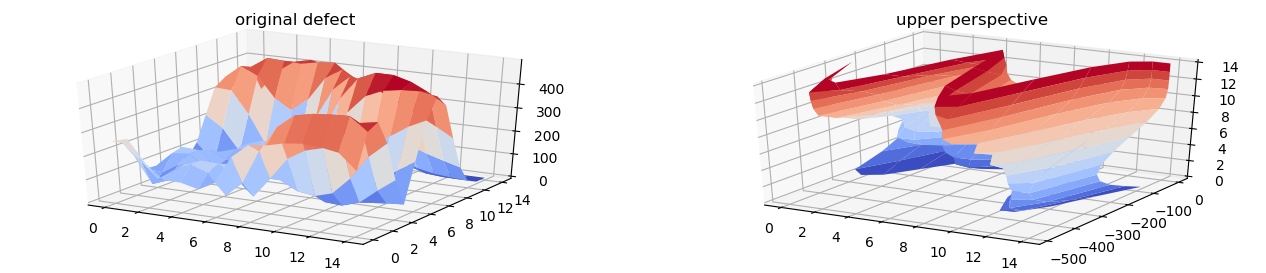

In [33]:
fig = plt.figure(figsize=plt.figaspect(0.2))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')


# Make data.
Z = (Norm,Norm)
X = np.arange(0, Z[0].shape[0], 1)
Y = np.arange(0, Z[0].shape[0], 1)
X, Y = np.meshgrid(X, Y)


# Plot the surface.
surf0 = ax0.plot_surface(X, Y, Z[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)


# Add a color bar which maps values to colors.

ax1 = fig.add_subplot(1, 2, 2, projection='3d')

surf1 = ax1.plot_surface( Y,-Z[0],X, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

ax0.set_title('original defect')
ax1.set_title('upper perspective')
plt.savefig('fig')

plt.show()

### All grad min

In [34]:
all_grad = np.abs(np.array([sg.convolve(case, operators[i,:,:], "valid") for i in range(4)]))

In [35]:
np.argmin(all_grad, axis=0)

array([[3, 0, 0, 1, 2, 2, 0, 0, 1, 1, 2, 2, 2, 1, 1],
       [3, 3, 1, 2, 2, 2, 3, 1, 1, 2, 2, 2, 2, 1, 1],
       [2, 3, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 1, 1],
       [2, 0, 3, 3, 2, 1, 1, 0, 0, 3, 2, 2, 1, 1, 2],
       [0, 0, 0, 3, 2, 1, 0, 0, 0, 0, 1, 3, 1, 1, 2],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3],
       [3, 0, 0, 1, 2, 3, 3, 0, 0, 0, 2, 2, 2, 2, 2],
       [2, 0, 1, 1, 2, 3, 3, 0, 1, 2, 2, 2, 2, 2, 2],
       [1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 0, 2, 2, 2, 0, 3, 3, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2],
       [1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2],
       [1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0],
       [1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0]], dtype=int64)

In [36]:
grad=np.min(all_grad,axis=0)
pd.DataFrame(grad)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,47.336426,39.384277,20.180176,7.072266,16.046875,25.293457,18.263916,58.016846,21.113770,76.564697,33.774658,30.241943,82.859619,44.368896,41.984863
1,17.413330,45.548340,14.955811,16.336670,12.424805,11.125244,13.707520,4.627686,69.571533,44.361328,14.588135,36.034668,105.748291,89.644287,99.572998
2,35.433594,7.972656,18.785400,24.168457,7.100342,44.272949,11.297363,8.407959,18.929688,10.964111,1.830566,35.572510,88.536621,69.684570,113.904541
3,23.595215,2.496094,18.458984,22.298340,1.954834,22.939941,19.144043,38.608154,5.124023,6.171631,9.558594,24.978271,18.838867,36.010254,84.857666
4,11.528809,12.681152,33.207031,15.160156,0.856201,13.738525,44.266357,35.843018,23.974609,16.396484,3.448242,3.204102,9.113770,10.592773,38.878174
5,20.099854,10.727783,2.008301,3.418213,0.765381,6.849121,6.977051,5.934326,2.966309,2.312744,1.418213,2.952881,3.009521,2.720703,5.437744
6,6.126221,0.322510,33.011230,5.932373,1.393555,5.691895,45.242920,41.920410,18.994141,6.524902,4.482422,18.323730,22.855957,34.322510,35.623291
7,3.664795,5.672607,2.742920,31.254395,4.903076,25.041992,15.791504,30.377686,12.526611,0.423340,28.258301,37.780518,51.239990,70.671143,62.351562
8,19.012695,12.072266,8.329834,17.795898,8.631836,41.016113,5.482910,14.645996,32.812988,62.644531,60.872559,53.373779,64.818604,84.877197,70.806396
9,27.465332,22.442871,2.321533,22.665283,10.386963,1.438965,14.173096,21.072754,68.618164,125.269043,86.661377,55.654541,54.123047,66.335693,53.918213


### plot grad for all directions

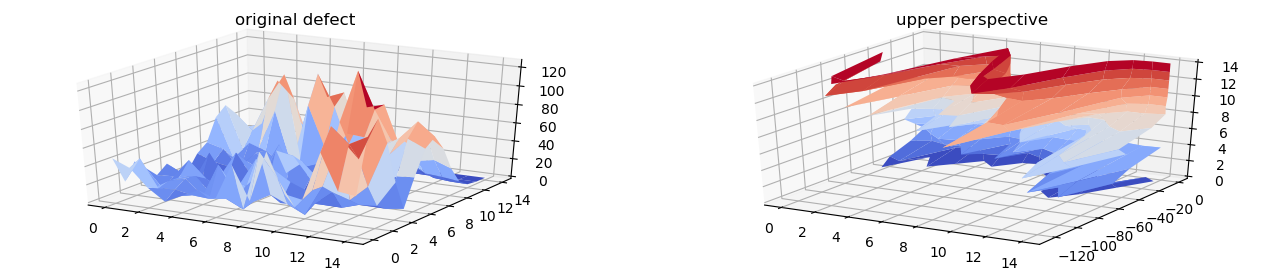

In [37]:
fig = plt.figure(figsize=plt.figaspect(0.2))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')


# Make data.
X = np.arange(0, grad.shape[0], 1)
Y = np.arange(0, grad.shape[0], 1)
X, Y = np.meshgrid(X, Y)
Z = (grad,grad)

# Plot the surface.
surf0 = ax0.plot_surface(X, Y, Z[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)


# Add a color bar which maps values to colors.

ax1 = fig.add_subplot(1, 2, 2, projection='3d')

surf1 = ax1.plot_surface( Y, -Z[0],X, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

ax0.set_title('original defect')
ax1.set_title('upper perspective')
plt.savefig('fig')

plt.show()

### Grad in 1D

In [38]:
new_grad = grad.ravel()
shape = new_grad.size
x = np.arange(shape)

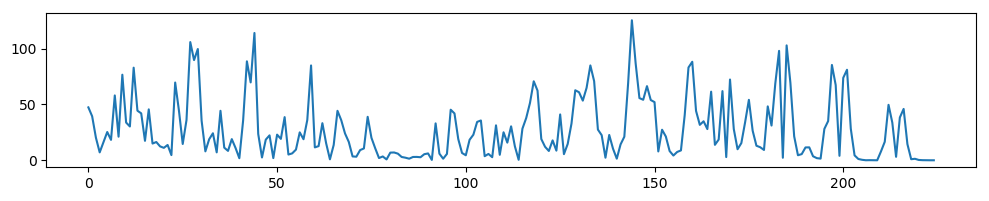

In [39]:
fig = plt.figure(figsize=(12,2))
#ax0=fig.add_subplot(1,2,1) # dans une grille de 1 ligne, 2 colonnes, on ajoute la première boite-graphique 
plt.plot(x,new_grad)
plt.show()

# Local minima

In [40]:
""" this function produce a rolling window which is just a view on the data: 
= a special way to move in the data. No copy is made.
"""
def rolling_windows_img(a,kshape):
    outShape=(a.shape[0]-kshape[0]+1,)+(a.shape[1]-kshape[1]+1,)+kshape
    outStrides=a.strides+a.strides
    return np.lib.stride_tricks.as_strided(a,shape=outShape,strides=outStrides)

In [41]:
'''neighbours: [[1,1,1],[1,0,1],[1,1,1]]'''
def findLocalMin(data,kshape,minimum):
    
    dataRoll = rolling_windows_img(data,kshape)
    a,b = dataRoll.shape[0],dataRoll.shape[1]
    L = a*b
    W = kshape[0]*kshape[1]
    dataRoll = dataRoll.reshape(L,W)
    
    if minimum == True:
        armin = np.argmin(dataRoll,axis=1)
    else:
        armin = np.argmax(dataRoll,axis=1)
    
    res=np.array([])
    for i, j in enumerate(armin):
        
        where = np.where((dataRoll[i,:] == dataRoll[i,j]))[0]
        
        if (j == W//2 and where.size == 1):
            coord = np.array([(i//b)+ kshape[0]//2,(i%a)+ kshape[1]//2])
            res = np.append(res, coord)
            
    
    res = res.reshape(res.size//2,2)
    print np.sort(res)
    
    return np.sort(res)

In [59]:
matrix = Norm
mini = findLocalMin(matrix,(3,3),True)

[[ 1.  2.]
 [ 2.  7.]
 [ 4.  5.]
 [ 5. 10.]
 [ 1.  8.]
 [ 7.  8.]
 [ 4. 10.]]


### Plot minima

In [70]:
def plot_matrix(matrix,mini,name):
    points = np.where(matrix !=0.0)
    pts = np.stack((points[1],points[0]),axis =-1)#i,j --> y,x
    plt.plot(pts[:,0],matrix.shape[0]-pts[:,1]-1,"+");
    for centroid in mini: #reverse a
        print centroid
        plt.plot(centroid[1],centroid[0],"o")
        plt.savefig(name)

[1. 2.]
[2. 7.]
[4. 5.]
[ 5. 10.]
[1. 8.]
[7. 8.]
[ 4. 10.]


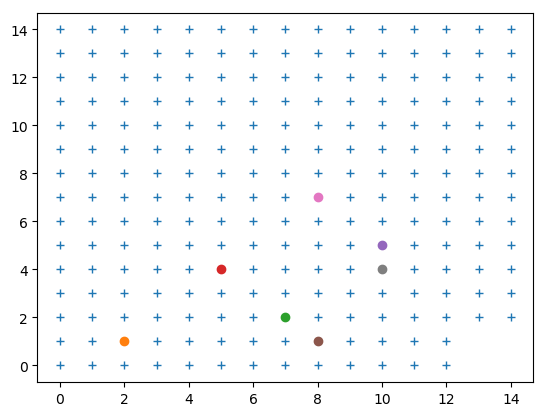

In [71]:
plot_matrix(matrix,mini,'fig minima')


In [58]:
matrix.shape

(15L, 15L)

### Kmeans

### Solution 1

In [188]:
from sklearn.cluster import KMeans

In [189]:
"""creation of the algo"""
kmeans=KMeans(n_clusters=2)
"""computation of centroids"""
kmeans.fit(pts)
"""here is the result"""
kmeans.cluster_centers_


array([[14.5    ,  9.5    ],
       [ 4.76923,  9.5989 ]])

In [190]:
labels = kmeans.predict(pts)

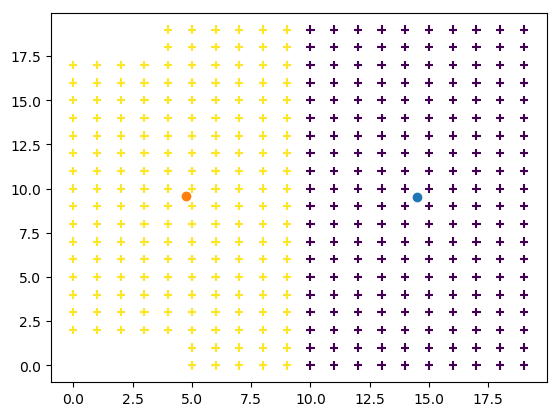

In [191]:
plt.scatter(pts[:,0],pts[:,1],c=labels,marker="+");
for centroid in kmeans.cluster_centers_:
    plt.plot(centroid[0],centroid[1],"o")

### Solution 2

In [192]:
kmeans.cluster_centers_ = np.fliplr(mini)# np.array([[ 3. , 8.],[15.,  8.]])

In [193]:
labels = kmeans.predict(pts)
labels.size == pts[:,1].size

True

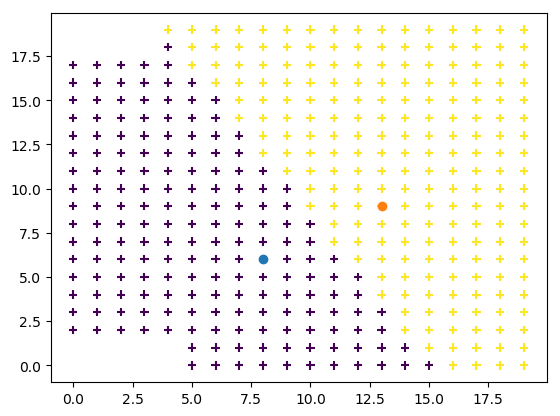

In [194]:
plt.scatter(pts[:,0],pts[:,1],c=labels,marker="+")
for centroid in kmeans.cluster_centers_:
    plt.plot(centroid[0],centroid[1],"o")